MicroGrad

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
def f(x):
    return 1 / (1 + x**2)

In [3]:
f(5.3)

0.034376074252320386

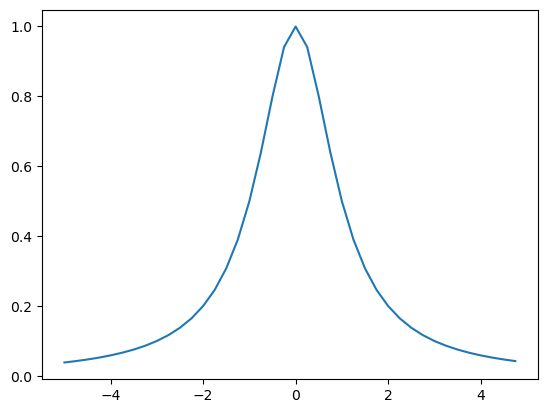

In [4]:
rx = np.arange(-5, 5, 0.25)
ry = f(rx)
plt.plot(rx, ry)

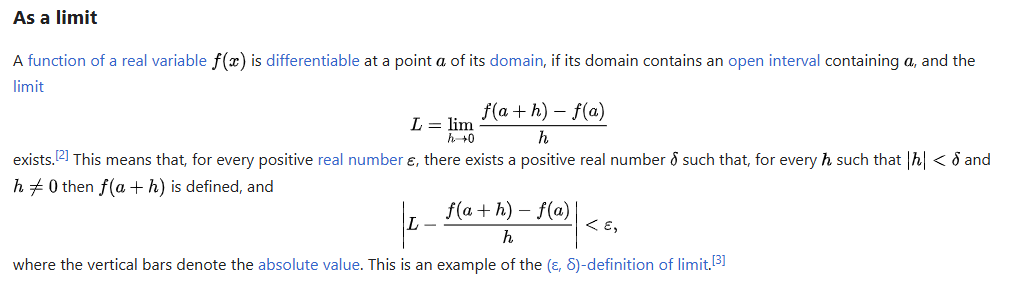

In [5]:
h = 0.0000000001
x = 0.3
f(x + h)
# f(x)

(f(x + h) - f(x)) / h

-0.5050082574342696

In [6]:
a = 5.0
b = -5.0
c = 10.0

d = a*b + c
print(d)

-15.0


In [7]:
h = 0.00000001

a = 5.0
b = -5.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c
# print(d1, d2)
print('slope = ', (d2 - d1) / h)


slope =  -5.000000058430487


In [108]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f'Value(data = {self.data})'
    
    def __add__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
        out = Value(self.data + other.data, (self, other), _op='+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
        out = Value(self.data * other.data, (self, other), _op='*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    def __rmul__(self, other):
        return self * other
    
    def __sub__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
        out = Value(self.data - other.data, (self, other), _op='-')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad -= 1.0 * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(x * 2.0) - 1.0) / (math.exp(x * 2.0) + 1.0)
        # print('x : ', x, '--> tanh : ', t)
        out = Value(t, (self,), _op='tanh')
        # print('tanh', out.data)
        def _backward():
            self.grad += (1.0 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self) :

        topo = []
        visited = set()
        
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        
        build_topo(self)
        
        self.grad = 1.0
        for v in reversed(topo):
            v._backward()
    

In [9]:
%pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [10]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

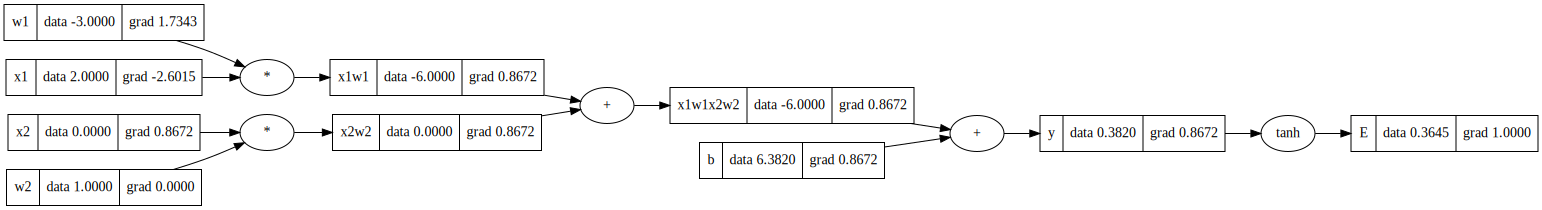

In [109]:
x1 = Value(2, label='x1')
x2 = Value(0, label='x2')
w1 = Value(-3, label='w1')
w2 = Value(1, label='w2')
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1w1x2w2'
b = Value(6.382011, label='b')
y = x1w1x2w2 + b; y.label = 'y'
E = y.tanh()
E.label = 'E'
E.backward()

draw_dot(E)